In this notebook, we perform basic width analysis using the segmentation of the channel network.

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from orinoco import (export_edges_to_geodataframe,
                     export_nodes_to_geodataframe,
                     change_tuples_to_vector,
                     get_array_from_features, 
                     apply_func_to_superpixels,
                     rasterize_shapes_to_array,
                     get_k_hop_neighborhood,
                     )
from skimage.color import label2rgb
import random
from shapely.geometry import Point
import geopandas as gpd
from tqdm import tqdm
import scipy.ndimage as nd
import scipy

# Setting up Data Paths

## Set up Paths to Tile Directory and GRWL Data Directory

The tile directory has the orinoco products and the GRWL directory has the original GRWL masks and centerlines.

In [2]:
grwl_data = Path('grwl_data')
grwl_data.exists()

True

In [3]:
tile_name = 'NR08'

tile_dir = Path(f'out/{tile_name}')
tile_dir.exists()

True

## Initializing Directory for Plots

In [4]:
plot_dir = Path(f'plot/width_analysis_{tile_name}')
plot_dir.mkdir(exist_ok=True, parents=True)

# Read the data from the Tile Directory

We read the segments, the water mask, and the channel network products.

In [5]:
with rasterio.open(tile_dir/f'segments_{tile_name}.tif') as ds:
    segments = ds.read(1)
    profile = ds.profile

with rasterio.open(tile_dir/f'water_mask_{tile_name}.tif') as ds:
    water_mask = ds.read(1)
    
rivG = nx.read_gpickle(tile_dir/f'{tile_name}_network.pkl')
edges_orinoco = gpd.read_file(tile_dir/f'{tile_name}_edges.geojson')
nodes_orinoco = gpd.read_file(tile_dir/f'{tile_name}_nodes.geojson')

# Read the GRWL Centerlines

We clipped the GRWL when creating the channel network above, so we will crop

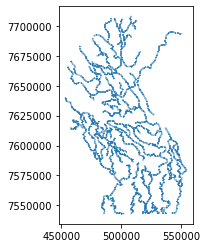

In [6]:
edges_grwl = gpd.read_file(grwl_data/'centerlines'/tile_name).to_crs(edges_orinoco.crs)
edges_grwl.plot()

# Width Analysis

To validate our widths, we will take all the centerlines that pass through a segment (using a rasterization of the centerline and take an average of these widths within the segment to determine the GRWL width within these segments. To do so, we first rasterize the centerlines.

## Rasterize GRWL Centerlines and their Widths

In [7]:
widths_raster_grwl = rasterize_shapes_to_array(edges_grwl.geometry.buffer(1e-7).tolist(),
                                               edges_grwl.width_m.tolist(),
                                               profile,
                                               all_touched=True)
widths_raster_grwl[widths_raster_grwl == 0] = np.nan

## Get Segment Average of GRWL Widths

In [8]:
def nan_mean(arr):
    nan_indices = np.isnan(arr)
    if np.sum(~nan_indices) > 0:
        return np.mean(arr[~nan_indices])
    else:
        return np.nan
    
width_features_grwl = apply_func_to_superpixels(nan_mean, segments, widths_raster_grwl)

## Find nodes away from junctions

We know that junctions in the network are hard to measure width. We recorde the dataframe of nodes that are not junctions so we can perform an analysis across all the segments and those that are away from junctions or not adjacenty to such segments.

In [9]:
degree_dict = dict(nx.degree(rivG))
node_to_label = nx.get_node_attributes(rivG, 'label')
junctions = [node for node, degree in degree_dict.items() if degree > 2]
neighborhood_of_junctions = list(set([node_to_label[neighbor] 
                                      for node in junctions
                                      # The radius specifies how many edges between the node are permitted
                                      # We consider junctions and those adjacent to them so radius = 1
                                      for neighbor in get_k_hop_neighborhood(rivG, node, radius=1)]))

nodes_orinoco_no_junctions = nodes_orinoco[~nodes_orinoco.label.isin(neighborhood_of_junctions)].copy()

print('No junctions: ', nodes_orinoco_no_junctions.shape)
print('All nodes: ', nodes_orinoco.shape[0])

No junctions:  (19506, 18)
All nodes:  23422


## Functions to Lookup Orinoco and Average GRWL Widths within a Segment

We perform our analysis within each segment comparing our width the average GRWL there. We can consider two cases:

1. All segments/nodes
2. Excluding segments/nodes within a 1-hop distance from a junction.

The latter will have lower errors due to the errors associated nearby a channel junction.

In [10]:
# To switch between cases
# select either 1. nodes_orinoco or 2. nodes_orinoco_no_junctions

df = nodes_orinoco_no_junctions.copy() # can be: 1. nodes_orinoco or 2. nodes_orinoco_no_junctions

label_to_width_dict = df.set_index('label').to_dict()['width_m']
def lookup_width(segment):
    label = segment.ravel()[0]
    return label_to_width_dict.get(label, np.nan)

label_to_width_segment_dict = df.set_index('label').to_dict()['width_from_segment']
def lookup_width_segment(segment):
    label = segment.ravel()[0]
    return label_to_width_segment_dict.get(label, np.nan)

Let $m$ be the total number of segments. We obtain two vectors of size $m \times 1$ such that the index $i$ value is the width either of the GRWL-derived width described above within segment $i$ or our methodology using Orinoco at that segment/node.

In [11]:
width_features_orinoco = apply_func_to_superpixels(lookup_width, segments, segments)
width_features_from_segment = apply_func_to_superpixels(lookup_width_segment, segments, segments)

Indeed the shapes from the GRWL-derived widths and the Orinoco widths have the same shape

In [12]:
print('Height of GRWL-derived widths vector', width_features_orinoco.shape)
print('Height of Orinoco width vector', width_features_orinoco.shape)
print('# of labels: ', len(np.unique(segments)))

Height of GRWL-derived widths vector (24562, 1)
Height of Orinoco width vector (24562, 1)
# of labels:  24562


# Plotting the Results

Again, we comparing:

1. The GRWL-derived widths within a segment.
2. The Orinoco widths widths within the same segment.
3. The distance transform-derived width within the same segment.

## Orinoco vs. Mean GRWL Width per Segment

In [13]:
x = width_features_orinoco.ravel()
y = width_features_grwl.ravel()

ind = (~np.isnan(x) 
       & ~np.isnan(y) 
      )

x = x[ind].copy()
y = y[ind].copy()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

bias = np.mean(x-y)
nbias = np.mean(x-y)/ np.mean(y) * 100
rmse = np.sqrt(np.mean((x-y)**2))
nrmse = np.sqrt(np.mean((x-y)**2)) / np.mean(y) * 100
slope = slope
intercept = intercept
r = r_value
r2 = r_value**2
mad = np.mean(np.abs(x - y))
nmad = np.mean(np.abs(x - y)) / np.mean(y) * 100
count = y.size

bias, nbias, rmse, nrmse, slope, intercept, r, r2, mad, nmad, count

(5.883925143655946,
 1.7161539349379167,
 162.72283982869072,
 47.46107998626998,
 1.0009514305401666,
 -6.215726316382927,
 0.9383540786504132,
 0.8805083769198658,
 45.73421908640743,
 13.339217976128673,
 10748)

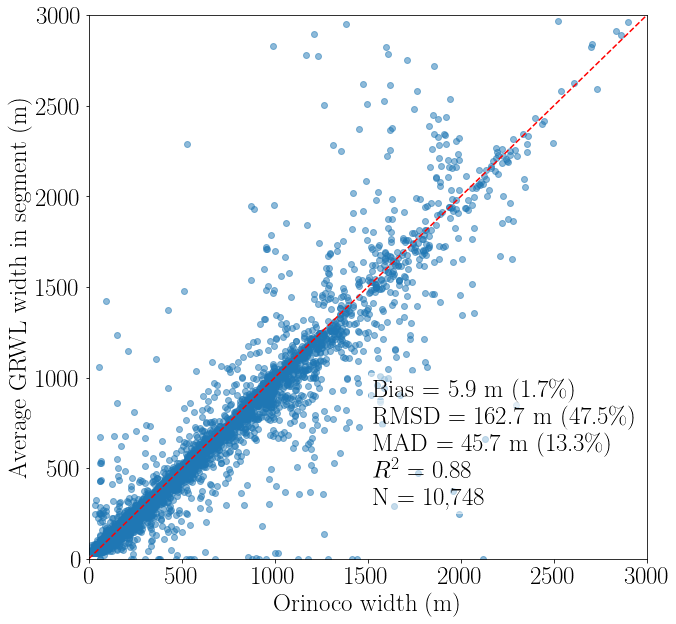

In [14]:
# Update font style globally
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=25)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, alpha=.5)

#std = min(2 * y.std(), 2 * x.std())
limit = 3_000 #max(x.max() - std, y.max() - std)
xx = np.linspace(0, limit, 100)
plt.plot(xx, xx, '--', c='red')
ax.set_xlabel('Orinoco width (m)')
ax.set_ylabel('Average GRWL width in segment (m)')
ax.set_xlim(0, limit)
ax.set_ylim(0, limit)

props={'facecolor': 'white',
       'edgecolor': 'white',
       'alpha': .5,}
ax.text(.51, .3, f'Bias = {bias:1.1f} m ({nbias:1.1f}\%)', transform=ax.transAxes, bbox=props)
ax.text(.51, .25, f'RMSD = {rmse:1.1f} m ({nrmse:1.1f}\%)', transform=ax.transAxes, bbox=props)
ax.text(.51, .2, f'MAD = {mad:1.1f} m ({nmad:1.1f}\%)', transform=ax.transAxes, bbox=props)
ax.text(.51, .15, f'$R^2$ = {r2:1.2f}', transform=ax.transAxes, bbox=props)
ax.text(.51, .1, f'N = {count:,}', transform=ax.transAxes, bbox=props)
plt.savefig(plot_dir/'width_final.png')

## Distance Transform vs. Mean GRWL Width per Segment

In [15]:
x = width_features_from_segment.ravel()
y = width_features_grwl.ravel()

ind = (~np.isnan(x) 
       & ~np.isnan(y) 
      )

x = x[ind].copy()
y = y[ind].copy()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

bias = np.mean(x-y)
nbias = np.mean(x-y)/ np.mean(y) * 100
rmse = np.sqrt(np.mean((x-y)**2))
nrmse = np.sqrt(np.mean((x-y)**2)) / np.mean(y) * 100
slope = slope
intercept = intercept
r = r_value
r2 = r_value**2
mad = np.mean(np.abs(x - y))
nmad = np.mean(np.abs(x - y)) / np.mean(y) * 100
count = y.size

bias, nbias, rmse, nrmse, slope, intercept, r, r2, mad, nmad, count

(-30.89804755559314,
 -9.011978330758087,
 174.09287397003703,
 50.77735753155599,
 1.0892913538134197,
 3.0429599595296963,
 0.9344666312832324,
 0.8732278849818326,
 44.87246671334458,
 13.087872201009757,
 10748)

In [16]:
ax.set_ylabel('Average GRWL Width in Segment (m)')

Text(32.063335976416575, 0.5, 'Average GRWL Width in Segment (m)')

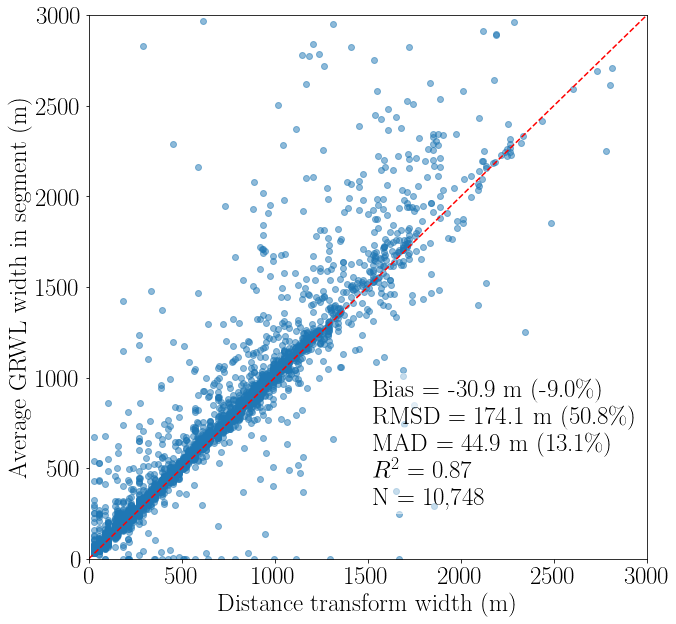

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, alpha=.5)

limit = 3_000 #max(x.max(), y.max())
xx = np.linspace(0, limit, 100)
plt.plot(xx, xx, '--', c='red')
ax.set_xlabel('Distance transform width (m)')
ax.set_ylabel('Average GRWL width in segment (m)')
ax.set_xlim(0, limit)
ax.set_ylim(0, limit)

ax.text(.51, .3, f'Bias = {bias:1.1f} m ({nbias:1.1f}\%)', transform=ax.transAxes, bbox=props)
ax.text(.51, .25, f'RMSD = {rmse:1.1f} m ({nrmse:1.1f}\%)', transform=ax.transAxes, bbox=props)
ax.text(.51, .2, f'MAD = {mad:1.1f} m ({nmad:1.1f}\%)', transform=ax.transAxes, bbox=props)
ax.text(.51, .15, f'$R^2$ = {r2:1.2f}', transform=ax.transAxes, bbox=props)
ax.text(.51, .1, f'N = {count:,}', transform=ax.transAxes, bbox=props)
plt.savefig(plot_dir/'width_dt.png')

# Visualizing the Geographic Width Deviations

Let's first get the map values of the difference.

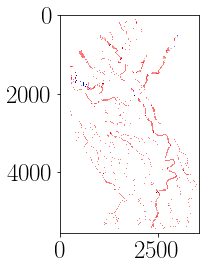

In [18]:
diff_features = width_features_orinoco - width_features_grwl
diff_array = get_array_from_features(segments, diff_features)
plt.imshow(diff_array, cmap='seismic')

We select areas to visualize this difference more easily. Note that some of the areas in the channel will not have difference data because either there is no centerline within the particular segment or we removed such a segment for analysis because it was a junction or adjacent to a junction.

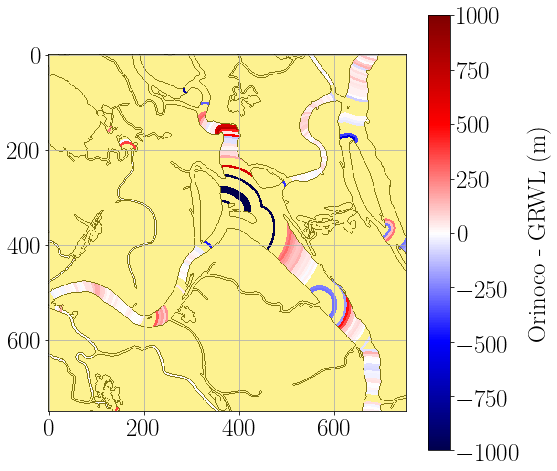

In [19]:
plt.figure(figsize=(8, 8))

# Select slices
index = np.s_[1750:2500, 1500:2250]
diff_crop = diff_array[index]


# Color nan values yellow
nan_values = np.isnan(diff_crop).astype(float)
nan_values[nan_values == 0] = np.nan
plt.imshow(nan_values, cmap='viridis_r')

# Create an outline of the channel mask using a binary dilation.
mask_crop = water_mask[index]
outline = nd.morphology.binary_dilation(mask_crop, iterations = 2).astype(float)
outline[mask_crop.astype(bool)] = 0.
plt.imshow(outline, cmap='binary', alpha=.5)

# Plot the width differences per segment
plt.imshow(diff_crop, cmap='seismic', vmin=-1000, vmax=1000)
plt.axis('on')
plt.grid('on')

plt.colorbar(label='Orinoco - GRWL (m)')

The same as above only over a different subarea.

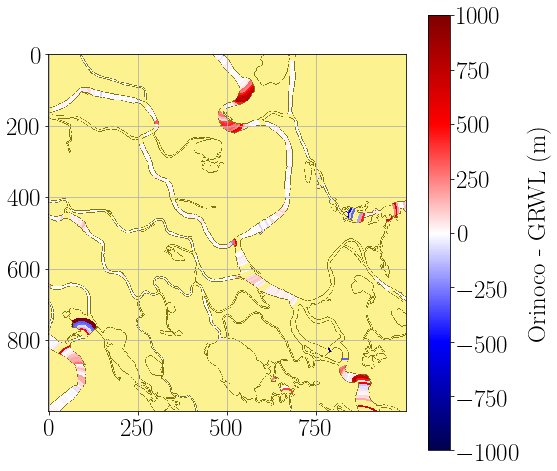

In [20]:
plt.figure(figsize=(8, 8))

# Select slices
index = np.s_[1000:2000, 1000:2000]
diff_crop = diff_array[index]


# Color nan values yellow
nan_values = np.isnan(diff_crop).astype(float)
nan_values[nan_values == 0] = np.nan
plt.imshow(nan_values, cmap='viridis_r')

# Create an outline of the channel mask using a binary dilation.
mask_crop = water_mask[index]
outline = nd.morphology.binary_dilation(mask_crop, iterations = 2).astype(float)
outline[mask_crop.astype(bool)] = 0.
plt.imshow(outline, cmap='binary', alpha=.5)

# Plot the width differences per segment
plt.imshow(diff_crop, cmap='seismic', vmin=-1000, vmax=1000)
plt.axis('on')
plt.grid('on')

plt.colorbar(label='Orinoco - GRWL (m)')

We will save the width difference array per segment for making pretty plots.

In [21]:
p = profile.copy()
p['dtype'] = 'float32'
p['nodata'] = np.nan
with rasterio.open(tile_dir/f'width_differences.tif', 'w', **p) as ds:
    ds.write(diff_array.astype(np.float32), 1)